# 四角に切れパズル

「四角に切れ」は、シンプルながらも奥深いロジックパズルの一種です。日本のパズル雑誌などで広まり、世界的にも人気があります。ルールは以下のようです。  

1. **長方形または正方形で分割**  
   - 与えられたグリッド（マス目）を長方形または正方形に分割します。  
2. **各領域に1つの数字**  
   - 各長方形または正方形には、問題に書かれた数字がちょうど1つだけ含まれるようにします。  
3. **数字の意味**  
   - 各数字は、その数字を含む長方形または正方形の**マスの総数**を示します。  
4. **重複・交差なし**  
   - すべてのマスを使用し、長方形や正方形が重ならないように配置します。
  
パズルの初期状態             |  解答
:-------------------------:|:-------------------------:
![](https://upload.wikimedia.org/wikipedia/commons/5/58/Shikaku_start.png) |  ![](https://upload.wikimedia.org/wikipedia/commons/e/ee/Shikaku_end.png)

## コード  

次のコードは「四角に切れ」パズルを解くものです。このコードでは、本書が提供する `SATHelper` を使用して CNF 式を作成します。`SATHelper` は、よく使われる CNF 式を作成するための複数のメソッドを提供します。  

* `SATHelper.next()`: 次の番号のブール変数を作成します。  
* `SATHelper.next(n)`: 次のブール変数を `n` 個作成します。  
* `SATHelper.exact_n(vs, n)`: ブール変数リスト `vs` の中で、`n` 個が `True` であるという制約を追加します。  
* `SATHelper.implies_all(a, vs)`: `vs` 内のすべてのブール変数 `x` に対して、`a → x` の制約を追加します。  

In [1]:
import numpy as np
from helper.sat import SATHelper
from collections import defaultdict
from itertools import product
from collections import namedtuple

Rectangle = namedtuple('Rect', 'x y w h')

def mult_pair(n):
    for i in range(1, n+1):
        j = n // i
        if i * j == n:
            yield i, j

def generate_rectangle(x, y, area, width, height):
    for w, h in mult_pair(area):
        for i, j in product(range(w), range(h)):
            x2 = x - i
            y2 = y - j
            if x2 >= 0 and y2 >= 0 and x2 + w <= width and y2 + h <= height:
                yield Rectangle(x2, y2, w, h)
                
def generate_cell(rect):
    x, y, w, h = rect
    for i, j in product(range(w), range(h)):
        yield x + i, y + j

class ShikakuSolver:
    def __init__(self, board):
        board = np.array(board)
            
        height, width = board.shape
        self.height = height
        self.width = width

        sat = SATHelper()
        rect_variables = {}
        for y, x in zip(*np.where(board > 0)):
            v = board[y, x]
            number_rects = {}
            for rect in generate_rectangle(x, y, v, width, height):
                number_rects[sat.next()] = rect
            rect_variables[x, y] = number_rects

        cells = defaultdict(set)
        for (x0, y0), number_rects in rect_variables.items():
            for v, rect in number_rects.items():
                for xc, yc in generate_cell(rect):
                    cells[xc, yc].add((x0, y0))

        cell_variables = {}
        for key, value in cells.items():
            cell_variables[key] = dict(zip(value, sat.next(len(value))))

        self.rect_variables = rect_variables
        self.cell_variables = cell_variables
        self.sat = sat
        self.board = board

    def solve(self):
        sat = self.sat
        rect_variables = self.rect_variables
        cell_variables = self.cell_variables
        
        for value in rect_variables.values():
            sat.exact_n(value.keys(), 1)

        for value in cell_variables.values():
            sat.exact_n(value.values(), 1)

        for pos, rects in rect_variables.items():
            for var_rect, rect in rects.items():
                var_cells = [cell_variables[xc, yc][pos] for xc, yc in generate_cell(rect)]
                sat.implies_all(var_rect, var_cells)
        
        self.solution = sol = sat.solve()
        if sol is not None:
            sol_rects = []
            for pos, rects in rect_variables.items():
                for var_rect, rect in rects.items():
                    if sol[var_rect - 1] > 0:
                        sol_rects.append(rect)    
            self.sol_rects = sol_rects
            return sol_rects
        else:
            return []

次のパズルを解いてみます。

In [3]:
board = [[2, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
        [9, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
        [0, 0, 0, 0, 16, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0],
        [0, 0, 0, 7, 0, 0, 0, 0, 2, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 18, 0, 2],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
        [0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 6, 0],
        [9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 5, 0],
        [0, 2, 2, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
        [0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 2],
        [0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0]]

solver = ShikakuSolver(board)
rects = solver.solve()

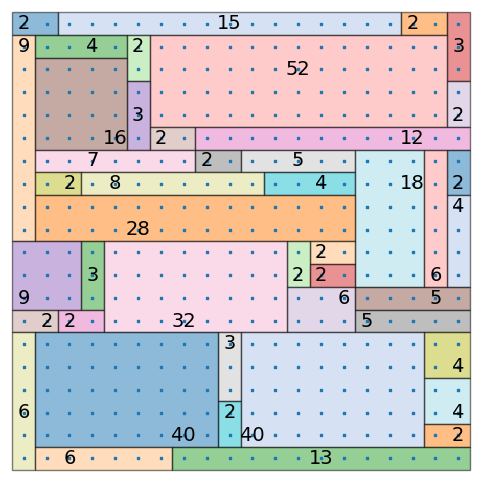

In [4]:
from matplotlib import pyplot as plt
from matplotlib.cm import tab20
from itertools import cycle

def plot_board(board, rects=[], figsize=(6, 6)):
    height, width = board.shape
    Y, X = np.where(board > 0)
    V = board[Y, X]
    
    colors = cycle(tab20.colors)
    fig, ax = plt.subplots(figsize=figsize)
    for rect in rects:
        x, y, w, h = rect
        ax.add_patch(plt.Rectangle((x, y), w, h, facecolor=next(colors), edgecolor='black', alpha=0.5))
    
    for x, y, v in zip(X, Y, V):
        ax.text(x + 0.5, y + 0.5, str(v), fontsize=14, ha='center', va='center')
    
    y, x = np.mgrid[:height, :width]
    
    ax.scatter(x.ravel() + 0.5, y.ravel() + 0.5, s=1, marker='s')
    
    ax.set_xlim(0-0.1, width+0.1)
    ax.set_ylim(0-0.1, height+0.1)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.axis('off')

plot_board(solver.board, rects)

## 解析

`rect_variables` は、各数字に対応する候補の矩形領域を辞書として保持します。辞書のキーはブール変数の番号、値はそのブール変数に対応する矩形の情報です。以下に、座標 (3, 1) の 数字4に対応するブール変数と矩形領域の例を示します。

In [5]:
solver.rect_variables[3, 1]

{26: Rect(x=3, y=1, w=1, h=4),
 27: Rect(x=3, y=0, w=1, h=4),
 28: Rect(x=3, y=1, w=2, h=2),
 29: Rect(x=3, y=0, w=2, h=2),
 30: Rect(x=2, y=1, w=2, h=2),
 31: Rect(x=2, y=0, w=2, h=2),
 32: Rect(x=3, y=1, w=4, h=1),
 33: Rect(x=2, y=1, w=4, h=1),
 34: Rect(x=1, y=1, w=4, h=1),
 35: Rect(x=0, y=1, w=4, h=1)}

この辞書内のすべてのブール変数のうち、ちょうど 1 つだけが `True` になるように、次のコードで制約を追加します。

```python
for value in rect_variables.values():
    sat.exact_n(value.keys(), 1)
```

次に、26 番から 35 番のブール変数の値を表示します。34 番が `True` であるため、`Rect(x=1, y=1, w=4, h=1)` が解となります。

In [91]:
[solver.solution[i] for i in range(25, 35)]

[-26, -27, -28, -29, -30, -31, -32, -33, 34, -35]

`cell_variables` は、各マスが所属する数字の情報を保持する辞書です。辞書のキーは数字の位置で、値はその数字に対応するブール変数の番号です。このブール変数が `True` の場合、該当するマスは対応する数字に所属することになります。

次に、マス(2, 1)の値を決める数字の位置と、それに対応するブール変数の番号を示します。

In [92]:
solver.cell_variables[2, 1]

{(0, 1): 1048, (3, 1): 1049, (12, 2): 1050}

この辞書内のすべてのブール変数のうち、ちょうど 1 つだけが `True` になるように、次のコードで制約を追加します。

```python
for value in cell_variables.values():
    sat.exact_n(value.values(), 1)
```

次に、上記のブール変数の値を確認します。1049 番のブール変数が `True` であるため、マス (2,1) は (3,1) の数字が作った矩形領域の中に含まれていることになります。  

In [93]:
[solver.solution[i] for i in [1047, 1048, 1049]]

[-1048, 1049, -1050]

`rect_variables` 内のブール変数と `cell_variables` 内の変数の間の制約条件は、ある矩形領域を表すブール変数が `True` の場合、その矩形領域内のすべてのマスが対応する数字と同じであることを保証します。次のコードで、この制約条件が設定されます。`implies_all(A, B)` は、`B` 内のすべての変数 `X` に対して、論理包含 `A → X` の制約をソルバーに追加します。  

```python
for pos, rects in rect_variables.items():
    for var_rect, rect in rects.items():
        var_cells = [cell_variables[xc, yc][pos] for xc, yc in generate_cell(rect)]
        sat.implies_all(var_rect, var_cells)
```

## SATHelperのソースコード

次は`SATHelper`中の`exact_n()`と`implies_all()`のソースコードです。

```python
def exact_n(self, variables, n, extend=True):
    cnfs = []
    variables = [int(v) for v in variables]
    for c in combinations(variables, n + 1):
        cnfs.append([-v for v in c])

    for c in combinations(variables, len(variables) - n + 1):
        cnfs.append([v for v in c])

    if extend:
        self.extend(cnfs)

    return cnfs

def implies(self, A, B, extend=True):
    if isinstance(B, int):
        B = [B]
    cnf = [-A] + B

    if extend:
        self.extend([cnf])

    return cnf

def implies_all(self, A, Bs, extend=True):
    cnfs = []
    for B in Bs:
        cnfs.append(self.implies(A, B, extend=extend))
    return cnfs        
```